In [14]:
# Change here using YOUR first and last names
fn1 = "Xiao"
ln1 = "Pan"
fn2 = "Yunzhi"
ln2 = "Wu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_pan_xiao_and_wu_yunzhi.ipynb


In [15]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

### Getting sparse coefficients

In [16]:
import numpy as np
from numpy.linalg import norm
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import check_grad
from IPython.display import Image

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

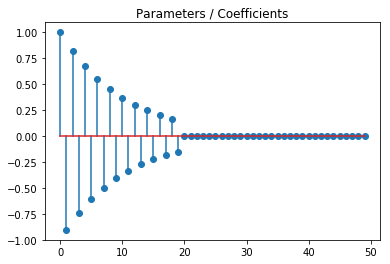

In [44]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [18]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

### Questions
- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso

### 1. Coding

In [19]:
def ridge(x,s):
    return 0.5 * s * x.dot(x)

def lasso(x,s):
    return s * np.linalg.norm(x, ord=1)

def prox_ridge(x, s, t=1.):
    return x/(1+s*t)

def prox_lasso(x, s, t=1.):
    y = np.zeros(x.size)
    for i in xrange(x.size):
        if x[i]>s*t:
            y[i] = x[i]-s*t
        if x[i]<-s*t:
            y[i] = x[i]+s*t
    return y
        

### 2. Visualization

(-2, 2)

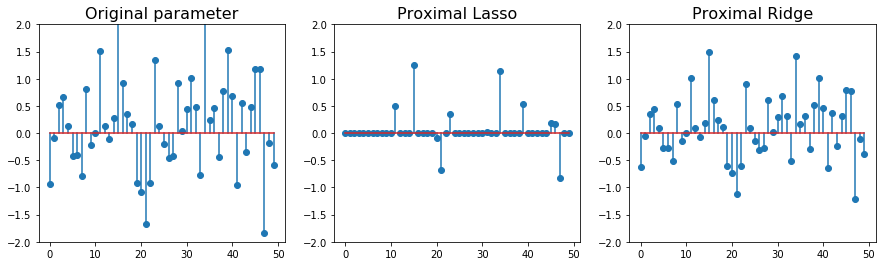

In [20]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

### Question
Comment what you observe (1 or 2 sentences).

### Answer
- 1.The coefficients after the ridge proximal operator all shirink with the same scale.
- 2.The relatively small coefficients all turn to zero after the lasso proximal operator, only the relatively large coefficients remain non-zero.

## Part 2: Gradients
The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

### Questions:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function checkgrad from scipy.optimize. Remark: use the functions simu_linreg and simu_logreg to simulate data according to the right model

### 1. Computation

**Linear regression**
$$
\triangledown f ~=~ \frac{1}{n}(A^TAx~-~A^Tb) 
$$
**Logistic regression**
$$
\triangledown f ~=~ \frac{1}{n}\sum \frac{-b_i \exp(-b_i a_i^\top x)}{1+\exp(-b_i a_i^\top x)}a_i
$$

### 2. Coding

In [21]:
def loss_linreg(x):
    """Least-squares loss"""
    n = b.size
    return 1./(2.*n) * np.linalg.norm(b-A.dot(x),ord = 2)**2

def grad_linreg(x):
    """Leas-squares gradient"""
    n = b.size
    return 1./n * (A.T.dot(A).dot(x)-A.T.dot(b))

def loss_logreg(x):
    """Logistic loss"""
    n = b.size
    sum = 0.0
    for i in xrange(n):
        tmp = (1.+np.exp(-b[i]*A[i].dot(x)))
        sum += np.log(tmp)
    return 1./n * sum

def grad_logreg(x):
    """Logistic gradient"""
    n = b.size
    grad = np.zeros(x.size)
    for i in xrange(n):
        grad = grad - b[i]*(A[i])*sigmoid(b[i]*A[i].dot(x))*np.exp(-b[i]*A[i].dot(x))
    return 1./n * grad

### 3. Check

In [22]:
A,b = simu_linreg(coefs, n_samples=1000, corr=0.5)
mu, sigma = 0, 0.1 # mean and standard deviation
x_lin = np.random.normal(mu, sigma, 50)
check_grad(loss_linreg, grad_linreg, x_lin)

1.328663665921489e-07

In [23]:
A,b = simu_logreg(coefs, n_samples=1000, corr=0.5)
mu, sigma = 0, 0.1 # mean and standard deviation
x_log = np.random.normal(mu, sigma, 50)
check_grad(loss_logreg, grad_logreg, x_log)

3.2397245521634706e-07

## Part 3: Solvers
We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

### Questions:
- Implement functions that compute the Lipschitz constants for linear and logistic regression losses. Note that the operator norm of a matrix can be computed using the function numpy.linalg.norm (read the documentation of the function)
- Finish the functions ista and fista below that implements the ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal Gradient Descent) algorithms

### 1. Compute the Lipschitz constants

#### Linear loss function:
Differentiating twice we have that :
$$\triangledown ^2(f)=A^T A$$
Consequently,
$$L \geq \sigma_{max}(\triangledown ^2(f)) = \left \| \triangledown ^2(f)  \right \|_2$$

#### Logistic loss function:
$$φ(α) = log(1 + e^α) \ is \  1–smooth$$
So,
$$f_i(x) = log(1 + exp(−b_i⟨x,a_i⟩)) \ \ is \ \ b_i^2 \left \| a_i  \right \|_2^2 \ –smooth$$
Thus,
$$ f(x) = \frac{1}{n}\sum_{i=1}^{n}f_i(x) \ \ is \ \frac{1}{n}\sum_{i=1}^{n}\ b_i^2 \left \| a_i  \right \|_2^2 \ -smooth$$
As $b_i^2 = 1$
$$ f(x) = \frac{1}{n}\sum_{i=1}^{n}f_i(x) \ \ is \ \frac{1}{n}\sum_{i=1}^{n}\left \| a_i  \right \|_2^2 \ -smooth$$
And
$$\sum_{i=1}^{n}\left \| a_i  \right \|_2^2 = \left \| A  \right \|_F^2$$
Consequently,
$$ f(x) = \frac{1}{n}\sum_{i=1}^{n}f_i(x) \ \ is \ \frac{1}{n}\left \| A  \right \|_F^2 \ -smooth$$
$$L = \frac{1}{n}\left \| A  \right \|_F^2$$

In [24]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return np.linalg.norm(A.T.dot(A),2)/A.shape[0]
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss""" 
    return np.linalg.norm(A,'fro')**2/A.shape[0]
    

### 2. Code of ISTA and FISTA algorithms

In [25]:
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    O = f(coefs) + g(coefs,s)
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(x-step*grad_f(x),s,step)
        x = x_new
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors, O

In [26]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    O = f(x_true) + g(x_true,s)
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(z-step*grad_f(z),s,step)
        t_new = (1.+np.sqrt(1.+4*t**2))/2.
        z_new = x_new + (t-1.)/t_new *(x_new-x)
        
        x = x_new
        z = z_new
        t = t_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors), O

## Algorithms comparison and numerical experiments

In [27]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
s = 1e-2

### Questions
- Compute a precise minimum and a precise minimizer of the linear regression with ridge penalization problem using the parameters give above. This can be done by using FISTA with 1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In [28]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
s = 1e-2

### 1. Compute a precise minimum and a precise minimizer

In [29]:
A,b = simu_linreg(coefs)
# linreg, ridge, ista
x_star_ir_lin, objectives_ir_lin, errors_ir_lin, O = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,
                                                       1./lip_linreg(A), s=s, n_iter=n_iter,x_true=coefs,verbose = False)

# linreg, ridge, fista
x_star_fr_lin, objectives_fr_lin, errors_fr_lin, O = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,
                                                        1./lip_linreg(A), s=s, n_iter=n_iter,x_true=coefs,verbose = False)

In [30]:
print("minimum: %f"%objectives_fr_lin[-1])
print("minimizer:")
print(x_star_fr_lin)

minimum: 0.485275
minimizer:
[  9.39e-01  -8.66e-01   8.16e-01  -7.36e-01   6.94e-01  -6.58e-01
   5.42e-01  -4.43e-01   4.19e-01  -3.50e-01   3.14e-01  -2.79e-01
   2.97e-01  -3.24e-01   3.05e-01  -2.73e-01   2.14e-01  -1.84e-01
   2.03e-01  -1.53e-01  -3.08e-02   4.60e-02  -4.36e-02   2.99e-03
  -5.28e-02   3.91e-02  -3.94e-03   1.09e-02   4.83e-02  -5.33e-02
   3.32e-02  -1.92e-05   3.30e-02  -7.21e-02   1.57e-02   2.93e-02
  -2.18e-02  -3.84e-02   1.62e-02   9.75e-04  -5.27e-02  -2.34e-02
   3.63e-02  -5.32e-02   4.36e-03   1.09e-02  -4.80e-02   3.22e-02
   1.96e-02  -2.82e-02]


### 2. Compare the convergences of ISTA and FISTA

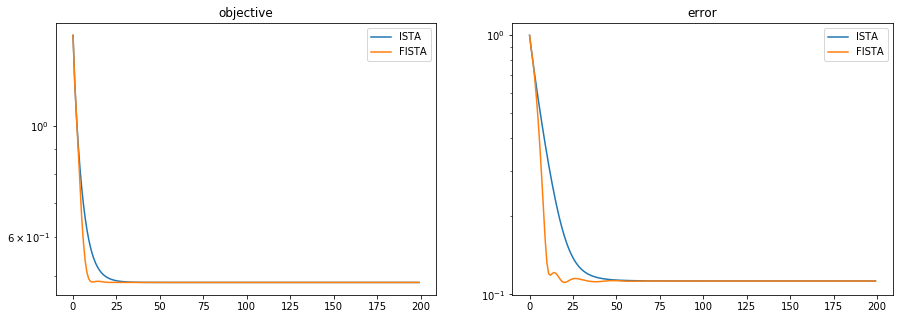

In [32]:
# plot
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(objectives_ir_lin[:200], label="ISTA")
plt.plot(objectives_fr_lin[:200], label="FISTA")
#plt.axhline(y=O, label="true objective", color='r', ls='--')
plt.yscale('log')
plt.legend()
plt.title("objective")
plt.subplot(122)
plt.plot(errors_ir_lin[:200], label="ISTA")
plt.plot(errors_fr_lin[:200], label="FISTA")
plt.yscale('log')
plt.legend()
plt.title("error")
plt.show()

#### Observation:
* With the same parameters and ridge penalty, ISTA and FISTA perform differently.<br\>
Using ISTA, x converges to the minimizer more slowly and smoothly, while by FISTA x converges quickly at the beginning and the value of error and objective function vibrates. The final out put of the two logarithms are the same.
Since the datas(A and b) simulated by x_true haven't taken penalty into consideration, it's normal that f(x_true)+g(x_true) is larger than the minimum given by our logarithms.

### Questions
- In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.
- In linear regression and logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. Explain.
- In linear regression and logistic regression, compare the performance of the optimization algorithms for ridge and lasso penalizations. Explain

### 1. The influence of the correlation of the features

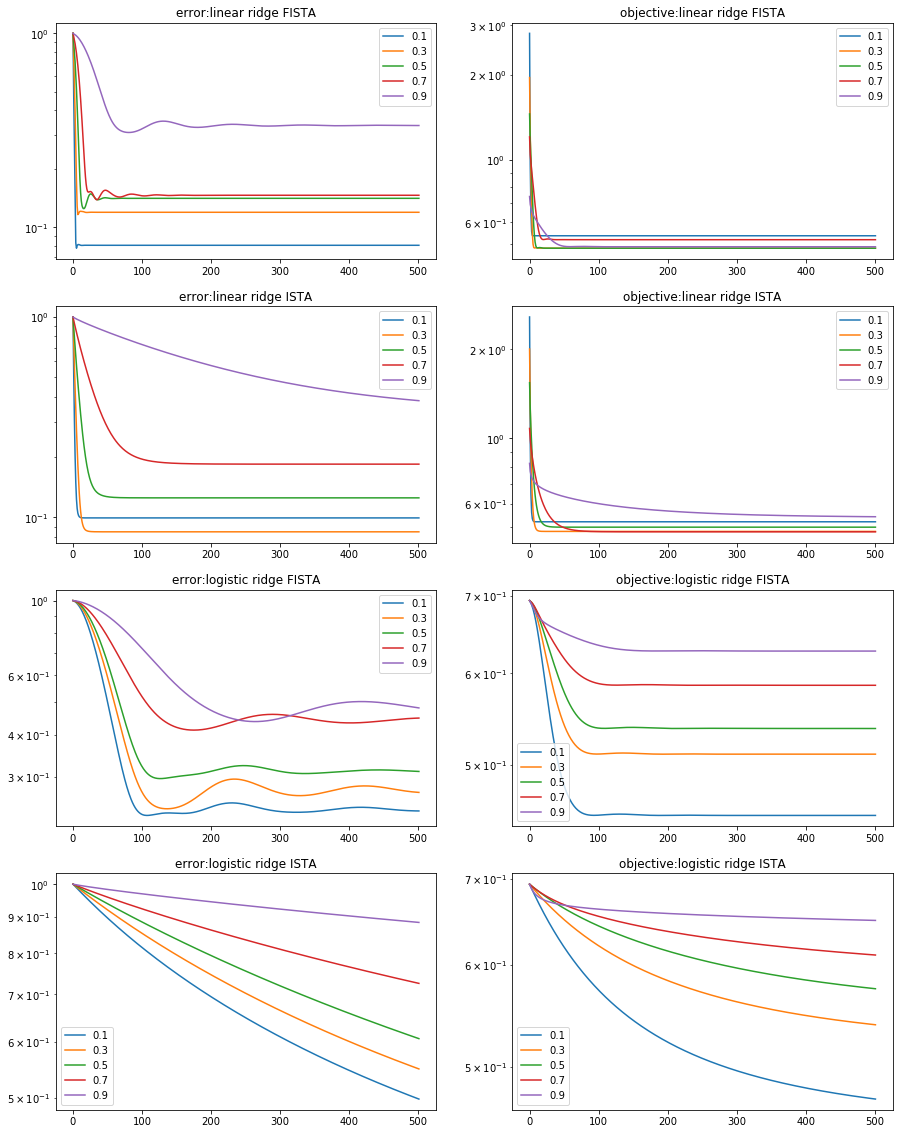

In [37]:
corrs=[0.1, 0.3, 0.5, 0.7, 0.9]
objs = []
errs = []
n_iter = 500
simu = simu_linreg
f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge
lip = lip_linreg
x_true = coefs
func=fista
s_f="linear"
s_g="ridge"
s_a="FISTA"
for i in xrange(len(corrs)):
    A,b = simu(x_true,corr=corrs[i])
    step = 1./lip(A)
    _,obj, err, O= func(x0, f, grad_f, g, prox_g, step, s, n_iter,x_true,verbose = False)
    objs.append(obj)
    errs.append(err)
# plot
plt.figure(figsize=(15,20))
plt.subplot(421)
for i in xrange(len(corrs)):
    plt.plot(errs[i], label=corrs[i])
plt.yscale('log')
plt.title("error:"+s_f+' '+s_g+' '+s_a)
plt.legend()

plt.subplot(422)
for i in xrange(len(corrs)):
    plt.plot(objs[i], label=corrs[i])
plt.yscale('log')
plt.title("objective:"+s_f+' '+s_g+' '+s_a)
plt.legend()

objs = []
errs = []

func=ista

s_a="ISTA"
for i in xrange(len(corrs)):
    A,b = simu(x_true,corr=corrs[i])
    step = 1./lip(A)
    _,obj, err, O= func(x0, f, grad_f, g, prox_g, step, s, n_iter,x_true,verbose = False)
    objs.append(obj)
    errs.append(err)
# plot

plt.subplot(423)
for i in xrange(len(corrs)):
    plt.plot(errs[i], label=corrs[i])
plt.yscale('log')
plt.title("error:"+s_f+' '+s_g+' '+s_a)
plt.legend()

plt.subplot(424)
for i in xrange(len(corrs)):
    plt.plot(objs[i], label=corrs[i])
plt.yscale('log')
plt.title("objective:"+s_f+' '+s_g+' '+s_a)
plt.legend()

objs = []
errs = []
s_f="logistic"
func=fista
simu = simu_logreg
s_a = 'FISTA'
f = loss_logreg
grad_f = grad_logreg
lip = lip_logreg

for i in xrange(len(corrs)):
    A,b = simu(x_true,corr=corrs[i])
    step = 1./lip(A)
    _,obj, err, O= func(x0, f, grad_f, g, prox_g, step, s, n_iter,x_true,verbose = False)
    objs.append(obj)
    errs.append(err)
# plot

plt.subplot(425)
for i in xrange(len(corrs)):
    plt.plot(errs[i], label=corrs[i])
plt.yscale('log')
plt.title("error:"+s_f+' '+s_g+' '+s_a)
plt.legend()

plt.subplot(426)
for i in xrange(len(corrs)):
    plt.plot(objs[i], label=corrs[i])
plt.yscale('log')
plt.title("objective:"+s_f+' '+s_g+' '+s_a)
plt.legend()

objs = []
errs = []

func=ista
s_a = 'ISTA'

for i in xrange(len(corrs)):
    A,b = simu(x_true,corr=corrs[i])
    step = 1./lip(A)
    _,obj, err, O= func(x0, f, grad_f, g, prox_g, step, s, n_iter,x_true,verbose = False)
    objs.append(obj)
    errs.append(err)
# plot

plt.subplot(427)
for i in xrange(len(corrs)):
    plt.plot(errs[i], label=corrs[i])
plt.yscale('log')
plt.title("error:"+s_f+' '+s_g+' '+s_a)
plt.legend()

plt.subplot(428)
for i in xrange(len(corrs)):
    plt.plot(objs[i], label=corrs[i])
plt.yscale('log')
plt.title("objective:"+s_f+' '+s_g+' '+s_a)
plt.legend()

plt.show()   



#### Observations and Explanations
- As the correlation increases, the algorithms converges worse, for linear loss and logistic loss.
- Correlation means the matrix A is not full rank, thus the regression will become unstable(with relatively small contidional number). Larger corrlation yields smaller conditional number, and the bigger the conditional number is, the faster the convergence will be.

### 2. The influence of the level of ridge penalization

In [34]:
def ista1(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # coefficients history
    xs = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        xs.append(x)
        x_new = prox_g(x-step*grad_f(x),s,t=step)
        x = x_new
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return np.array(xs).T, objectives, errors

In [35]:
def fista1(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # coefficients history
    xs = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        xs.append(x)
        x_new = prox_g(z-step*grad_f(z),s,t=step)
        t_new = (1.+np.sqrt(1.+4*t**2))/2.
        z_new = x_new + (t-1.)/t_new *(x_new-x)
        
        x = x_new
        z = z_new
        t = t_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return np.array(xs).T, np.array(objectives), np.array(errors)

In [36]:
def penalization(str,s,func,f,grad_f,g,prox_g,lip,n_iter):
    xs,_,_ = func(x0, f, grad_f, g, prox_g, 1./lip(A), s=s, n_iter=n_iter, x_true=coefs, verbose=False)
    plt.figure(figsize=(15,4))
    plt.plot(xs[0],label='$x_0=%.2f$'%coefs[0])
    plt.plot(xs[10],label='$x_{5}=%.2f$'%coefs[5])
    plt.plot(xs[20],label='$x_{10}=%.2f$'%coefs[10])
    plt.plot(xs[30],label='$x_{20}=%.2f$'%coefs[20])
    plt.legend()
    plt.title(str+" shirinkage with penalization = %.4f"%s)
    plt.show()
    return xs[0][-1],xs[5][-1],xs[10][-1],xs[15][-1],xs[20][-1]

In [38]:
def compare2(x0,f,grad_f,g,prox_g,step,ss,n_iter,x_true,func,s_f,s_g,s_a):

    objs = []
    errs = []
    true_obj = []
    for k in range(len(ss)):
        s = ss[k]
        x_star, objectives, errors, O = func(x0, f, grad_f, g, prox_g, step, s, n_iter,x_true,verbose = False)
        objs.append(objectives)
        errs.append(errors)
        true_obj.append(O)
    # plot
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    for i in xrange(len(ss)):
        plt.plot(errs[i], label=ss[i])
    plt.yscale('log')
    plt.legend()
    plt.title("error:"+s_f+' '+s_g+' '+s_a)
    plt.legend()

    plt.subplot(122)
    for i in xrange(len(ss)):
        plt.plot(objs[i], label=ss[i])
        
    plt.yscale('log')
    plt.legend()
    plt.title("objective:"+s_f+' '+s_g+' '+s_a)
    plt.legend()

    plt.show()



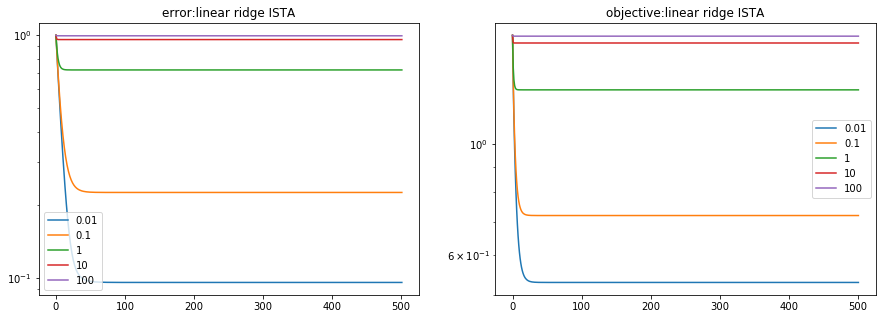

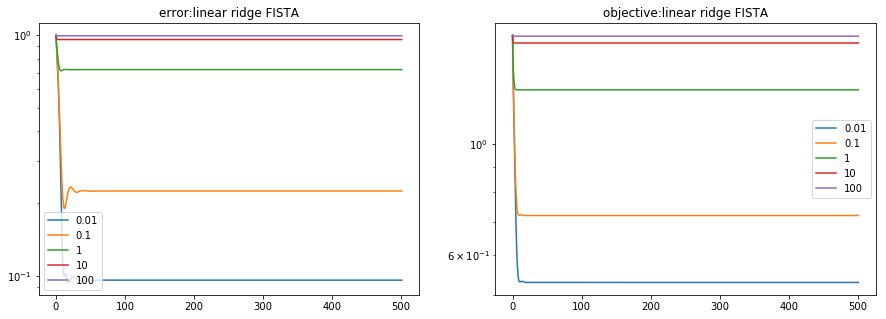

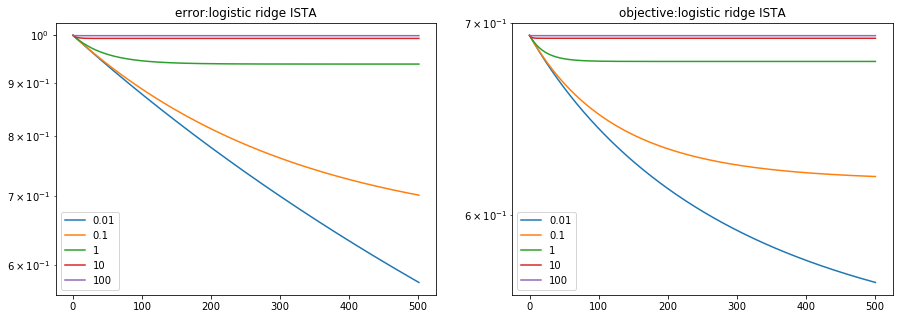

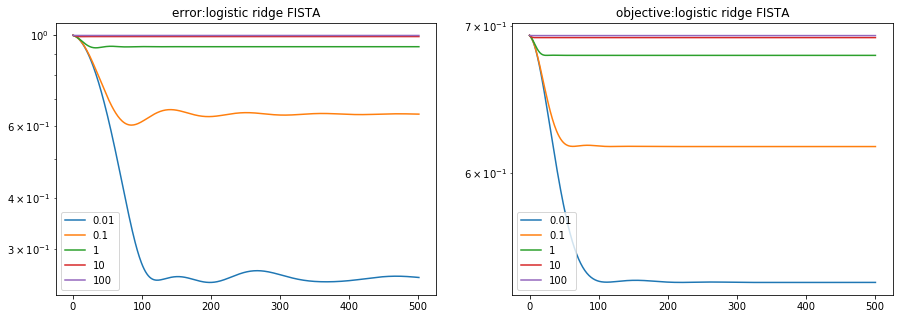

In [45]:
p = 50     
x0 = np.zeros(n_features)
ss = [0.01,0.1,1,10,100]
n_iter = 500
A,b = simu_linreg(coefs)
compare2(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1./lip_linreg(A), ss=ss, n_iter=n_iter,x_true=coefs,func=ista,s_f="linear",s_g="ridge",s_a="ISTA")
compare2(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1./lip_linreg(A), ss=ss, n_iter=n_iter,x_true=coefs,func=fista,s_f="linear",s_g="ridge",s_a="FISTA")
A,b = simu_logreg(coefs)
compare2(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1./lip_logreg(A), ss=ss, n_iter=n_iter,x_true=coefs,func=ista,s_f="logistic",s_g="ridge",s_a="ISTA")
compare2(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1./lip_logreg(A), ss=ss, n_iter=n_iter,x_true=coefs,func=fista,s_f="logistic",s_g="ridge",s_a="FISTA")

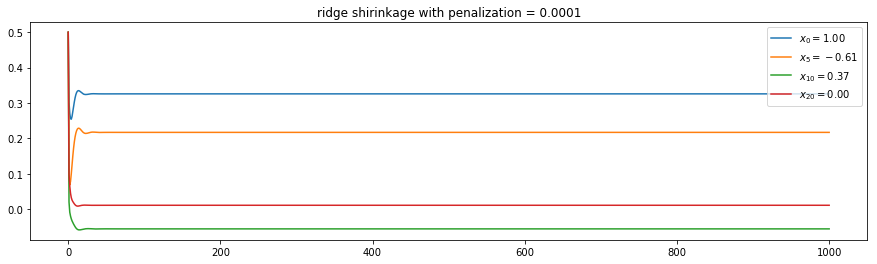

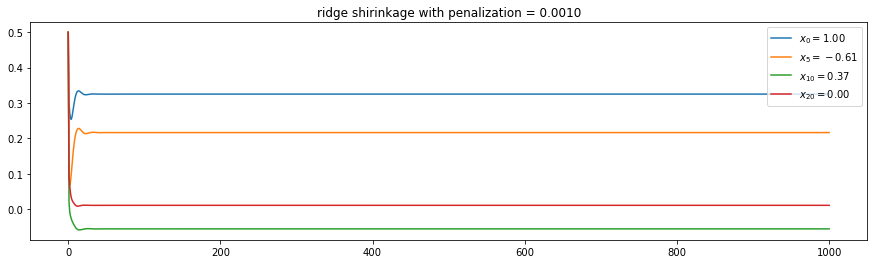

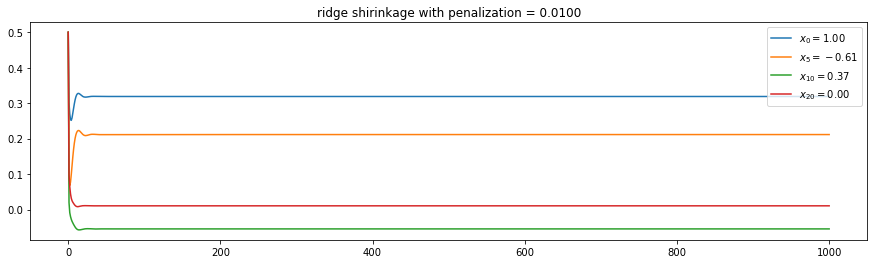

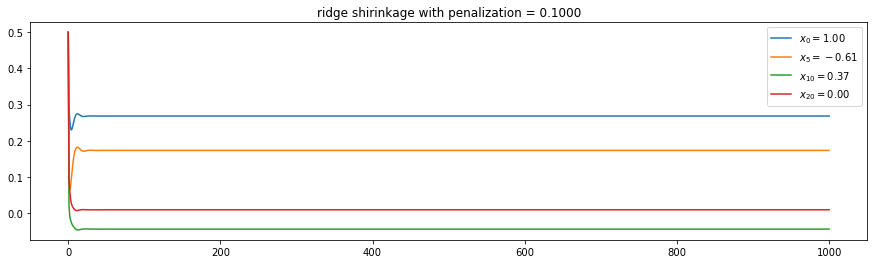

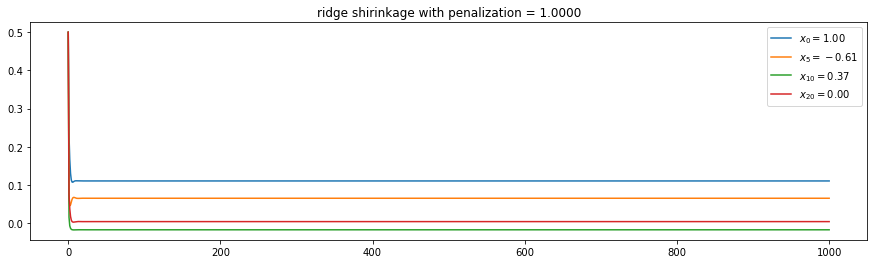

   s     |    x0    |    x5    |   x10    |   x15    |   x20   
    coef |     1.00 |    -0.61 |     0.37 |    -0.22 |     0.00
  0.0001 |   0.3258 |  -0.1963 |   0.2169 |  -0.0812 |  -0.0560
  0.0010 |   0.3251 |  -0.1957 |   0.2164 |  -0.0810 |  -0.0559
  0.0100 |   0.3189 |  -0.1899 |   0.2115 |  -0.0791 |  -0.0545
  0.1000 |   0.2683 |  -0.1469 |   0.1734 |  -0.0645 |  -0.0442
  1.0000 |   0.1103 |  -0.0456 |   0.0649 |  -0.0265 |  -0.0177


In [46]:
x0 = 0.5*np.ones(n_features)
ss = [0.0001,0.001,0.01,0.1,1]
xss = []

for s in ss:
    xx = penalization("ridge",s,fista1,loss_linreg,grad_linreg,ridge,prox_ridge,lip_linreg,1000)
    xss.append(xx)
    
#print np.array(xss).T
print(' | '.join([name.center(8) for name in ["s", "x0","x5","x10","x15","x20"]]))
print(' | '.join([name.center(8) for name in ["coef".rjust(8), 
                                              ("%.2f"%coefs[0]).rjust(8),
                                              ("%.2f"%coefs[5]).rjust(8),
                                              ("%.2f"%coefs[10]).rjust(8),
                                              ("%.2f"%coefs[15]).rjust(8),
                                              ("%.2f"%coefs[20]).rjust(8)]]))
for i in xrange(len(ss)):
    print(' | '.join([("%.4f"%ss[i]).rjust(8), 
                      ("%.4f" % xss[i][0]).rjust(8),
                      ("%.4f" % xss[i][1]).rjust(8),
                      ("%.4f" % xss[i][2]).rjust(8),
                      ("%.4f" % xss[i][3]).rjust(8),
                      ("%.4f" % xss[i][4]).rjust(8)]))

#plt.title("Parameters / Coefficients")

#### Obeservations and Explanations
* In ISTA or FISTA, logistic regression or linear regression, x converges better with smaller penalty coefficient. 

- The ridge proximal operator is x/(1+s*t), which implies the x shrinks faster as s becomes larger.


### 3. Compare ridge and lasso penalizations

In [47]:
def compare3(x0,f,grad_f,gs,prox_gs,step,s,n_iter,x_true,func,s_f,s_gs,s_a,corr):
    objs = []
    errs = []
    for i in xrange(len(gs)):
        x_star, objectives, errors,O = func(x0, f, grad_f, gs[i], prox_gs[i], step, s, n_iter,x_true,verbose = False)
        objs.append(objectives)
        errs.append(errors)
    # plot
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    for i in xrange(len(gs)):
        plt.plot(errs[i], label=s_gs[i])
    plt.yscale('log')
    plt.legend()
    plt.title("error:"+s_f+' '+s_a+' '+"s=%f"%s+' '+"corr=%f"%corr)
    plt.legend()

    plt.subplot(122)
    for i in xrange(len(gs)):
        plt.plot(objs[i], label=s_gs[i])
    plt.yscale('log')
    plt.legend()
    plt.title("objective:"+s_f+' '+s_a+' '+"s=%f"%s+' '+"corr=%f"%corr)
    plt.legend()

    plt.show()

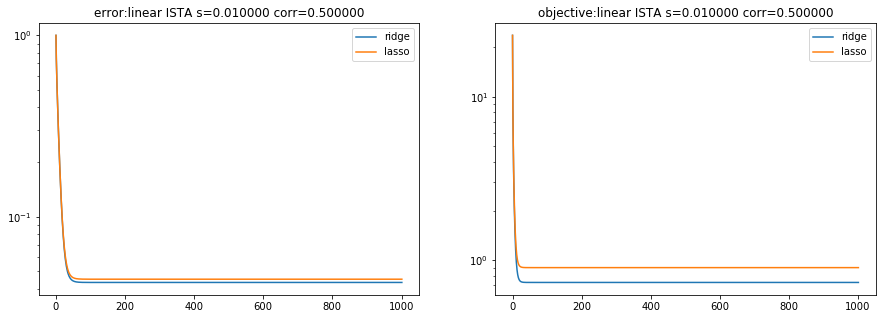

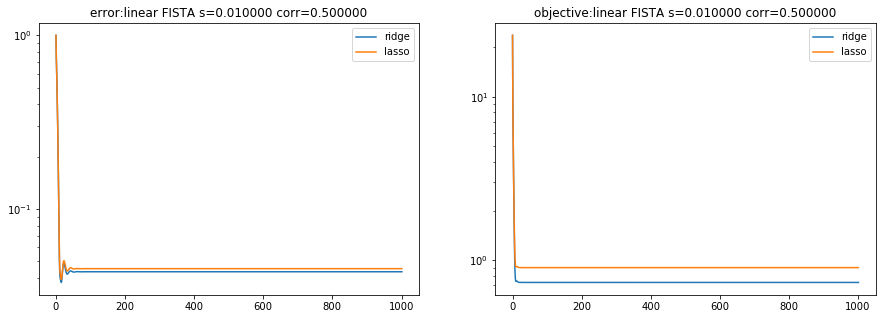

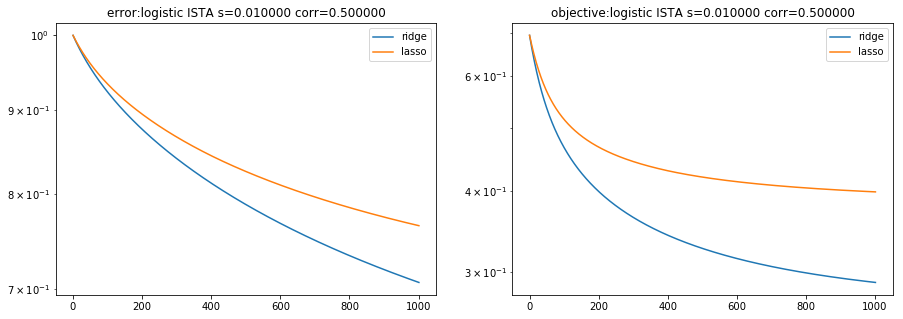

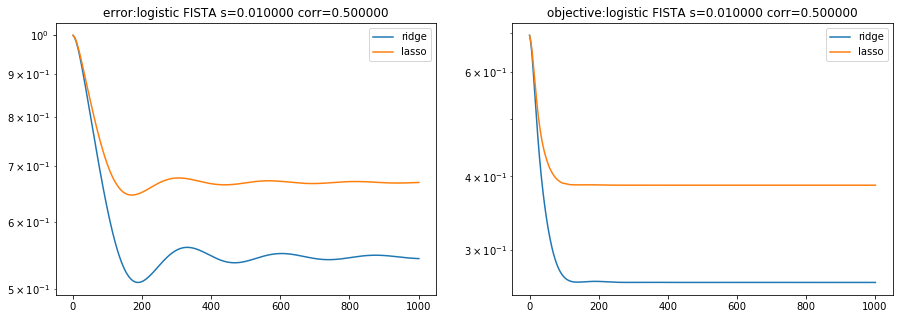

In [48]:
p = 50
coefs = randn(p)
x0 = np.zeros(n_features)
n_iter = 1000
s = 0.01

gs = [ridge,lasso]
prox_gs = [prox_ridge,prox_lasso]
s_gs = ["ridge","lasso"]
A,b = simu_linreg(coefs)
compare3(x0, loss_linreg, grad_linreg, gs, prox_gs, 1./lip_linreg(A), s=s, n_iter=n_iter,x_true=coefs,s_f = "linear",func = ista,s_gs = s_gs,s_a = "ISTA",corr=0.5)
compare3(x0, loss_linreg, grad_linreg, gs, prox_gs, 1./lip_linreg(A), s=s, n_iter=n_iter,x_true=coefs,s_f = "linear",func = fista,s_gs = s_gs,s_a = "FISTA",corr=0.5)

A,b = simu_logreg(coefs)
compare3(x0, loss_logreg, grad_logreg, gs, prox_gs, 1./lip_logreg(A), s=s, n_iter=n_iter,x_true=coefs,s_f = "logistic",func = ista,s_gs = s_gs,s_a = "ISTA",corr=0.5)
compare3(x0, loss_logreg, grad_logreg, gs, prox_gs, 1./lip_logreg(A), s=s, n_iter=n_iter,x_true=coefs,s_f = "logistic",func = fista,s_gs = s_gs,s_a = "FISTA",corr=0.5)

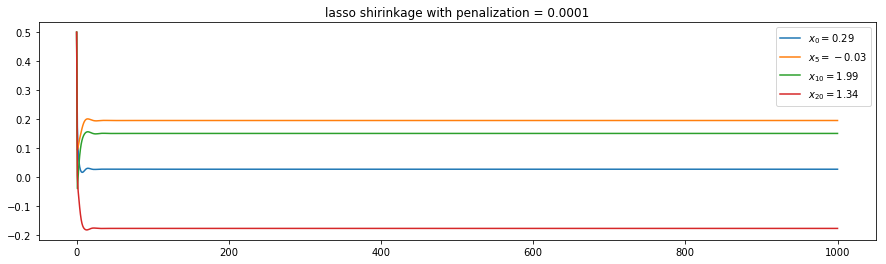

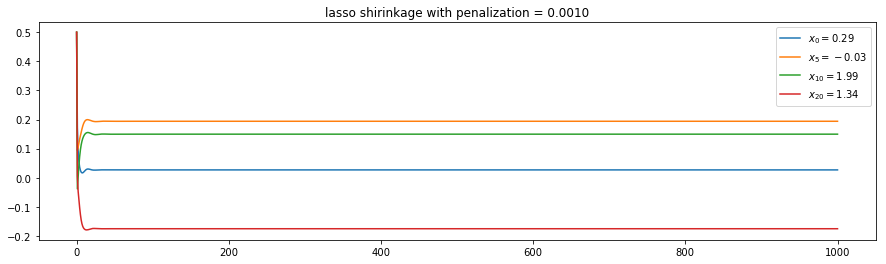

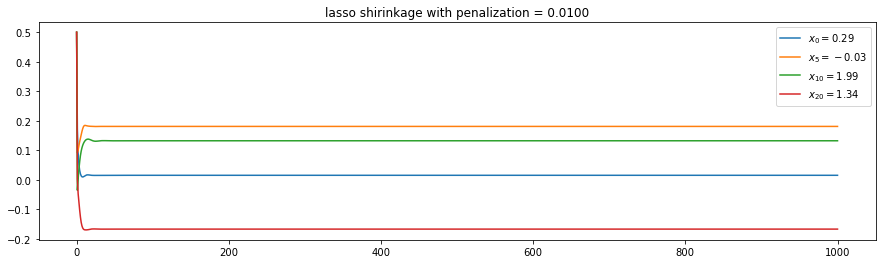

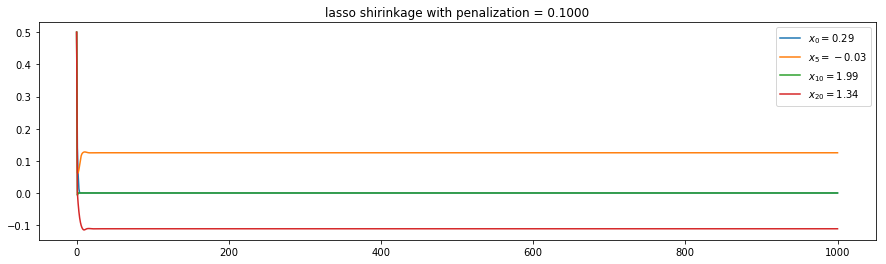

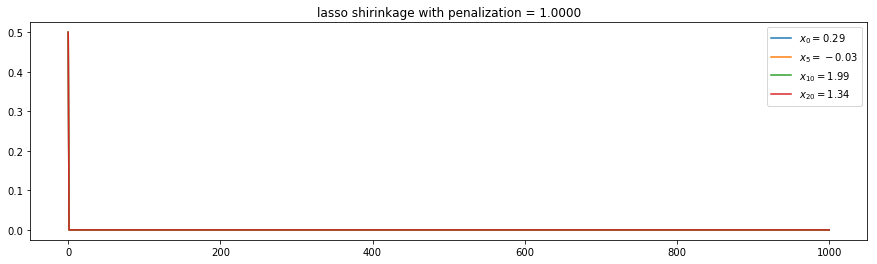

   s     |    x0    |    x5    |   x10    |   x15    |   x20   
    coef |     0.29 |    -0.03 |     1.99 |     0.25 |     1.34
  0.0001 |   0.0281 |  -0.0216 |   0.1959 |   0.0662 |   0.1514
  0.0010 |   0.0268 |  -0.0200 |   0.1940 |   0.0632 |   0.1496
  0.0100 |   0.0150 |  -0.0020 |   0.1807 |   0.0342 |   0.1321
  0.1000 |   0.0000 |   0.0000 |   0.1251 |   0.0000 |   0.0000
  1.0000 |   0.0000 |   0.0000 |   0.0000 |   0.0000 |   0.0000


In [49]:
x0 = 0.5*np.ones(n_features)
ss = [0.0001,0.001,0.01,0.1,1]
xss = []

for s in ss:
    xx = penalization("lasso",s,fista1,loss_linreg,grad_linreg,lasso,prox_lasso,lip_linreg,1000)
    xss.append(xx)
    
#print np.array(xss).T
print(' | '.join([name.center(8) for name in ["s", "x0","x5","x10","x15","x20"]]))
print(' | '.join([name.center(8) for name in ["coef".rjust(8), 
                                              ("%.2f"%coefs[0]).rjust(8),
                                              ("%.2f"%coefs[5]).rjust(8),
                                              ("%.2f"%coefs[10]).rjust(8),
                                              ("%.2f"%coefs[15]).rjust(8),
                                              ("%.2f"%coefs[20]).rjust(8)]]))
for i in xrange(len(ss)):
    print(' | '.join([("%.4f"%ss[i]).rjust(8), 
                      ("%.4f" % xss[i][0]).rjust(8),
                      ("%.4f" % xss[i][1]).rjust(8),
                      ("%.4f" % xss[i][2]).rjust(8),
                      ("%.4f" % xss[i][3]).rjust(8),
                      ("%.4f" % xss[i][4]).rjust(8)]))

#plt.title("Parameters / Coefficients")

#### Observations and Explanations
- The Lasso penality will reduce some efficients strictly to zero while the Ridge penality will never reduce any coefficients to exact zero.

The optimization problem of Ridge Penality


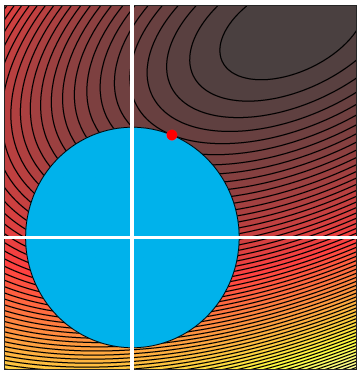

In [50]:
print "The optimization problem of Ridge Penality"
Image(filename="1.png")

The optimization problem of Lasso Penality


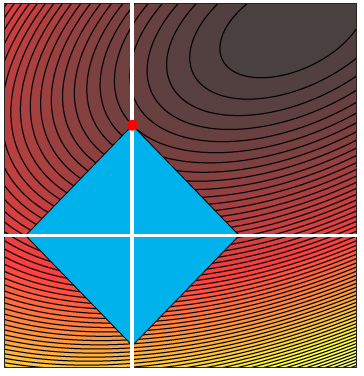

In [51]:
print "The optimization problem of Lasso Penality"
Image(filename="2.png")

- In the lasso optimization problem, the restriction can be seen as a square, the minimiser of the objective function is obtained at the vertex (the point 0).
- In the lasso optimization problem, the restriction can be seen as is a circle, which have no vertex, the minimiser of the objective function will never be obtained at the point 0.